### <font size="7"> <b> Calculating HAND from DEM</b></font>

<font size="5">  How to obtain Height Above Nearest Drainage using a BIG Digital Elevation Model with PySheds </font>

<br>
<font size="4"> <b> Part of NASA A.37 Project:</b> Integrating SAR Data for Improved Resilience and Response to Weather-Related Disasters   <br>
<font size="4"> <b> PI:</b>Franz J. Meyer <br>
<font size="3"> Version 0.1.3 - 2020/07/17 <br>
<b>Change Log</b><br>
2020/09/17: <br>
- BugFix: Evan Smith (BYU) reported an issue which was resulting from the basin mapping to a 1pixel-wide DEM. Modified code to skip single pixel wide or high DEM patches. 
2020/07/21: <br>
- BugFix: Certain DEM projections was causing Inf values when global datasets were reprojected. Added a clipping step before projecting global datasets to DEM projection. 
2020/06/02: <br>
- BugFix: Added individual HydroBasin links for each region. <br>
- BugFix: Clearing no-longer used variables before final nan-fill loop. Also skipping nan-fill if region is bigger than 1 Million pixels. <br>
- BugFix: Moved export before display to make sure Hand is saved before attempting anything else when result is ready.<br>
</font> 
<font color='rgba(0,0,200,0.2)'> <b>Contact: </b> batuhan.osmanoglu@nasa.gov </font>


<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3"> The first step in any notebook is to import the required Python libraries into the Jupyter environment. In this notebooks we use the following libraries:
<ol type="1">
    <li> <b><a href="https://www.gdal.org/" target="_blank">GDAL</a></b> is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.</li>
    <li> <b><a href="http://www.numpy.org/" target="_blank">NumPy</a></b> is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects. </li>
    <li> <b><a href="https://www.tutorialspoint.com/matplotlib/matplotlib_pylab_module.htm" target="_blank">PyLab</a></b> is a procedural interface to the Matplotlib object-oriented plotting library. Matplotlib is the whole package; matplotlib.pyplot is a module in Matplotlib; and PyLab is a module that gets installed alongside Matplotlib.</li>
    <li> <b><a href="https://github.com/mdbartos/pysheds" target="_blank">PySHEDS</a></b> is a new python module developed by Matt Bartos with the motto "Simple and fast watershed delineation in python." We use the Height Above Nearest Drainage (HAND) implementation in PySHEDS.</li>
    <li> <b><a href="https://github.com/Toblerity/Fiona" target="_blank"> Fiona </a></b> reads and writes geographic data files and thereby helps Python programmers integrate geographic information systems with other computer systems. Fiona contains extension modules that link the Geospatial Data Abstraction Library (GDAL). </li>
    <li> <b><a href="https://github.com/Toblerity/Shapely" target="_blank"> Shapely </a></b>allows for manipulation and analysis of geometric objects in the Cartesian plane. Shapely is not concerned with data formats or coordinate systems, but can be readily integrated with packages that are.</li>
    <li> <b><a href="https://geopandas.org/" target="_blank"> GeoPandas </a></b> is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.</li>
    <li> <b><a href="https://www.astropy.org/" target="_blank"> The Astropy Project </a></b> is a community effort to develop a core package for astronomy using the Python programming language and improve usability, interoperability, and collaboration between astronomy Python packages. The core astropy package contains functionality aimed at professional astronomers and astrophysicists, but may be useful to anyone developing astronomy software.</li>
    <li> <b><a href="https://github.com/tqdm/tqdm" target="_blank"> tqdm </a></b> is a smart progress meter that allows easy addition of a loop counter.</li>

In [1]:
#Setup Environment
import os
import sys
import numpy as np
import gdal,osr
import pylab as pl
from functools import partial
import warnings #Suppress warnings on occasion
#The two lines below are for visually browsing and selecting the DEM. 
import ipywidgets as ui
from IPython.display import display
#All packages below are used to support pysheds. 
try:
    import pysheds
except:
    !pip install pysheds
    import pysheds
from pysheds.grid import Grid
try:
    from affine import Affine
except:
    !pip install affine
    from affine import Affine
try:
    import rasterio
except:
    !pip install rasterio
    import rasterio
try:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")#, category=FutureWarning)    
        import pyproj
except:
    !pip install pyproj
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")#, category=FutureWarning)
        import pyproj #Pyproj is showing a lot of future warnings. 
        #/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
#This is for masking the DEM based on hydrobasins shapefile.
try:
    import fiona
except:
    !pip install fiona
    import fiona
import fiona.crs
try:
    import shapely
except:
    !pip install shapely
    import shapely
from shapely.ops import transform
try:
    import geopandas as gpd
except:
    !pip install geopandas
    import geopandas as gpd
#Astropy and scipy ndimage is to interpolate over nans in final HAND. 
try:
    import astropy
except:
    !pip install --user astropy
    import astropy
import astropy.convolution
from scipy import ndimage
#pretty loop counter
try:
    from tqdm.auto import tqdm
except:
    !pip install tqdm
    from tqdm.auto import tqdm


Processing /home/jovyan/.cache/pip/wheels/e4/87/6f/f67cbfbc39ea2c76e0cb801c37590b9e3c47e9eee7baea2547/pysheds-0.2.7-cp37-none-any.whl
  Using cached affine-2.3.0-py2.py3-none-any.whl (15 kB)
  Using cached geojson-2.5.0-py2.py3-none-any.whl (14 kB)
     |████████████████████████████████| 18.3 MB 13.4 MB/s eta 0:00:01
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached cligj-0.5.0-py3-none-any.whl (5.7 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
     |████████████████████████████████| 14.8 MB 17.4 MB/s eta 0:00:01
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached geopandas-0.8.1-py2.py3-none-any.whl (962 kB)


<font size="5"> <b> 1. Define convenience functions </b> </font>

<font size="3"> Here we define some functions for later convenience.
    
<ol type="1">
    <li> <b>fiona_read_vectorfile</b> returns a list of shapes (and optionally properties) using fiona. </li>
    <li> <b>intersect</b> returns polygons from multiple 'geometries' read by fiona.</li>
    <li> <b>reproject</b> reprojects a given vector file to another reference frame (CRS). </li>
    <li> <b>xy2coord</b> converts pixel index to position based on geotransform. </li>     
    <li> <b>get_projection</b> returns the spatial reference system in wkt, proj4, or epsg formats.</li>
    <li> <b>gdal_get_geotransform</b> returns the geotransform of the dataset using GDAL. </li>
    <li> <b>gdal_get_size</b> returns width and height for a given raster file. </li>
    <li> <b>gdal_bounding_box</b> returns the bounding box in geocoded coordinates for a given raster file. </li>    
    <li> <b>gdal_write</b> is used to export the generated HAND product using GDAL. </li>
    <li> <b>fill_nan</b> is used to fill small not-a-number areas in final HAND product if necessary. </li>
    <li> <b>calculate_hand</b> returns the height above nearest drainage for a given DEM using the pySheds library. </li>
    

In [2]:
%matplotlib notebook

def fiona_read_vectorfile(vectorfile, get_property=None):
    """shapes=fiona_read_vectorfile(vectorfile, get_property=None)
       shapes, props=fiona_read_vectorfile(vectorfile, get_property='Property_Name')
       Returns a list of shapes (and optionally properties) using fiona.
       
       vectorfile: any fiona compatible vector file. 
       get_property: String for the property to be read. 
       shapes: List of vector "geometry"
       props:  List of vector "properties"
    """
    with fiona.open(vectorfile, "r") as shpf:
        shapes   = [ feature["geometry"] for feature in shpf ]
        print(f"Number of shapes loaded: {len(shapes)}")
        if get_property is not None:
            props = [ feature["properties"][get_property] for feature in shpf ]
            return shapes, props
        else:
            return shapes    

def fiona_write_vectorfile(shapes, vectorfile, crs=fiona.crs.from_epsg(4326), driver='ESRI Shapefile', schema_type='Polygon'):
    if schema_type=='Polygon':
        schema={'geometry': 'Polygon',
                'properties': {}}        
    with fiona.open(vectorfile, 'w',crs=crs,driver=driver, schema=schema) as output:
        for s in shapes:
            if schema_type=='Polygon':
                sp= shapely.geometry.Polygon(s)
            output.write({'geometry':shapely.geometry.mapping(sp),'properties': {}})    
        
def intersect(shapes, polygon, properties=None):
    """
    polygons=intersect(shapes, polygon, properties=None)
    Returns polygons from multiple 'geometries' read by fiona.
    
    shapes: shapes returned by fiona_read_vectorfile()
    polygon: a single polygon to intersect with shapes
    properties: If not none, returns the property value instead of polygon geometry.
    """
    #first loop to split multi polygons to single polygons
    polygons=[]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")    
        for k,shape in tqdm(enumerate(shapes)):
            if shape['type']=='MultiPolygon':
                for l,p in enumerate(shape['coordinates']):
                    s=shapely.geometry.Polygon(p[0])
                    if polygon.intersects(s) and properties is None:            
                        polygons.append(s)
                    elif polygon.intersects(s) and properties is not None:
                        if np.isscalar(properties[k]):
                            polygons.append(properties[k])
                        else:
                            polygons.append(properties[k][l])
                    
            elif shape['type']=='Polygon':
                s=shapely.geometry.Polygon(shape['coordinates'][0])
                if polygon.intersects(s) and properties is None:
                    polygons.append(s)
                elif polygon.intersects(s) and properties is not None:
                    polygons.append(properties[k])
    return polygons

def reproject(vector_file, output_crs, output_file=None):
    """
    output_file=reproject(vector_file, output_crs, output_file=None)
    Reprojects a given vector file to another reference frame (CRS). 
    vector_file: Any vector file that can be opened with GeoPandas
    output_crs: A rasterio opened crs (e.g. dem.crs)
    output_file: if not defined, defaults to vector_file[:-4]+'_warp.shp'. 
    """
    v=gpd.GeoDataFrame.from_file(vector_file)
    warp=v.to_crs(output_crs)
    if output_file is None:
        output_file=vector_file[:-4]+'_warp.shp'
    warp.to_file(output_file)
    return output_file

def transform_shape(shape, s_srs='epsg:4326', t_srs='epsg:4326'):
    transformation=partial(
               pyproj.transform,
               pyproj.Proj(init=s_srs), #source coordinate system
               pyproj.Proj(init=t_srs)) #destination coordinate system
    return shapely.ops.transform(transformation, shape)

def xy2coord(x,y,gT):
    '''
    lon,lat=xy2coord(x,y,geoTransform)
    converts pixel index to position based on geotransform.
    '''
    coord_x=gT[0] + x*gT[1] + y*gT[2]
    coord_y=gT[3] + x*gT[4] + y*gT[5]
    return coord_x, coord_y

#def get_proj4(filename):
#    """proj4=get_proj4(filename)
#    Return Proj4 string using rasterio and pyproj. 
#    """
#    f=rasterio.open(filename)
#    return pyproj.Proj(f.crs, preserve_units=True)  #used in pysheds

def get_projection(filename, out_format='proj4'):
    """
    epsg_string=get_epsg(filename, out_format='proj4')
    """
    try:
      ds=gdal.Open(filename, gdal.GA_ReadOnly)
      srs=gdal.osr.SpatialReference()
      srs.ImportFromWkt(ds.GetProjectionRef())
    except: #I am not sure if this is working for datasets without a layer. The first try block should work mostly.
      ds=gdal.Open(filename, gdal.GA_ReadOnly)
      ly=ds.GetLayer()
      if ly is None:
        print(f"Can not read projection from file:{filename}")
        return None
      else:
        srs=ly.GetSpatialRef()
    if out_format.lower()=='proj4':
      return srs.ExportToProj4()
    elif out_format.lower()=='wkt':
      return srs.ExportToWkt()
    elif out_format.lower()=='epsg':
      crs=pyproj.crs.CRS.from_proj4(srs.ExportToProj4())
      return crs.to_epsg()

def gdal_get_geotransform(filename):
    '''
    [top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution]=gdal_get_geotransform('/path/to/file')
    '''
    #http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    ds = gdal.Open(filename)
    return ds.GetGeoTransform()

def gdal_get_size(filename):
    """(width, height) = get_size(filename)
    """
    ds = gdal.Open(filename)
    width = ds.RasterXSize
    height = ds.RasterYSize
    ds=None
    return (width, height)

def gdal_bounding_box(filename):
    """
    ((lon1,lat1), (lon2,lat2), (lon3,lat3), (lon4,lat4))=bounding_box('/path/to/file')
    """
    gT=gdal_get_geotransform(filename)
    width, height=gdal_get_size(filename)     
    return (xy2coord(0,0,gT), xy2coord(width,0,gT), xy2coord(width, height,gT), xy2coord(0, height,gT))

def gdal_write(ary, geoTransform, fileformat="GTiff", filename='jupyter_rocks.tif', format=gdal.GDT_Float64, nodata=None, srs_proj4='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'):
    '''gdal_write(ary, geoTransform, format="GTiff", filename='jupyter_rocks.tif', format=gdal.GDT_Float64 nodata=None, srs_proj4='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
    ary: 2D array.
    geoTransform: [top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution]
    format: "GTiff"     
    '''           
    if ary.ndim ==2:
      Ny, Nx = ary.shape
      Nb = 1;
    elif ary.ndim==3:
      Ny,Nx,Nb=ary.shape
    else: 
      print("Input array has to be 2D or 3D.")
      return None
    
    driver = gdal.GetDriverByName(fileformat)
    ds = driver.Create(filename, Nx, Ny, Nb, gdal.GDT_Float64)

    #ds.SetGeoTransform( ... ) # define GeoTransform tuple
    # top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
    ds.SetGeoTransform( geoTransform )    
    srs=osr.SpatialReference()
    srs.ImportFromProj4(srs_proj4)
    ds.SetProjection(srs.ExportToWkt() );
    if nodata is not None:
        ds.GetRasterBand(1).SetNoDataValue(0);
    if Nb==1:
      ds.GetRasterBand(1).WriteArray(ary)
    else:
      for b in range(Nb):
        ds.GetRasterBand(b+1).WriteArray(ary[:,:,b])
    ds = None
    print("File written to: " + filename);

def fill_nan(arr):
    """
    filled_arr=fill_nan(arr)
    Fills Not-a-number values in arr using astropy. 
    """    
    kernel = astropy.convolution.Gaussian2DKernel(x_stddev=3) #kernel x_size=8*stddev
    arr_type=arr.dtype          
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        while np.any(np.isnan(arr)):
            arr = astropy.convolution.interpolate_replace_nans(arr.astype(float), kernel, convolve=astropy.convolution.convolve)
    return arr.astype(arr_type) 

def calculate_hand(dem, dem_gT, dem_proj4, mask=None, verbose=False):
    """
    hand=calculate_hand(dem, dem_gT, dem_proj4, mask=None, verbose=False)
    Calculate the height above nearest drainage using pySHEDS library. This is done over a few steps:

    Fill_Depressions fills depressions in a DEM (regions of cells lower than their surrounding neighbors).
    Resolve_Flats resolves drainable flats in a DEM.
    FlowDir converts the DEM to flow direction based on dirmap.
    Accumulation converts from flow direction to flow accumulation.
    Compute_Hand is used to convert directions to height above nearest drainage.
    
    NaN values are filled at the end of resolve_flats and final steps. 
    
    Inputs:
      dem=Numpy array of Digital Elevation Model (DEM) to convert to HAND. 
      dem_gT= GeoTransform of the input DEM
      dem_proj4=Proj4 string of DEM
      mask=If provided parts of DEM can be masked out. If not entire DEM is evaluated. 
      verbose=If True, provides information about where NaN values are encountered. 
    """
    
    #Specify  directional mapping
    dirmap = (64, 128, 1, 2, 4, 8, 16, 32) 
    #Load DEM into pySheds
    if type(dem_gT)==Affine:
        aff=dem_gT
    else:
        aff=Affine.from_gdal(*tuple(dem_gT))
    if mask is None:
        mask=np.ones(dem.shape, dtype=np.bool)
    grid=Grid(shape=dem.shape,affine=aff, crs=dem_proj4, mask=mask)
    grid.add_gridded_data(dem, data_name='dem',affine=aff, crs=dem_proj4, mask=mask)        
    #Fill Depressions
    grid.fill_depressions('dem', out_name='flooded_dem')
    #Resolve_Flats 
    #Please note that Resolve_Flats currently has an open bug and can fail on occasion. https://github.com/mdbartos/pysheds/issues/118
    try:
        grid.resolve_flats('flooded_dem', out_name='inflated_dem')
    except:
        grid.inflated_dem=grid.flooded_dem
    if np.any(np.isnan(grid.inflated_dem)):
        if verbose:
            print('NaN:resolve_flats')
        grid.inflated_dem=fill_nan(grid.inflated_dem)                
    #Obtain flow direction
    grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
    #Obtain accumulation
    grid.accumulation(data='dir', dirmap=dirmap, out_name='acc')
    #Generate HAND
    grid.compute_hand('dir', 'inflated_dem', grid.acc >100, out_name='hand')
    #Copy HAND as an array. 
    hand=grid.view('hand')
    if np.any(np.isnan(grid.hand)):
        if verbose:
            print('NaN:compute_hand')
            grid.hand=fill_nan(grid.hand) 
    return hand


<font size="5"> <b> 1.1 Path Selector </b> </font>

<font size="3"> Path selector is used to select a raster DEM as as input to the HAND calculation. 
    

In [3]:
class PathSelector():
    """
    Displays a file selection tree. Any file can be selected. 
    Selected path can be obtained by: PathSelector.accord.get_title(0)
    """
    def __init__(self,start_dir,select_file=True):
        self.file        = None 
        self.select_file = select_file
        self.cwd         = start_dir
        self.select      = ui.SelectMultiple(options=['init'],value=(),rows=10,description='') 
        self.accord      = ui.Accordion(children=[self.select]) 

        self.accord.selected_index = None # Start closed (showing path only)
        self.refresh(self.cwd)
        self.select.observe(self.on_update,'value')

    def on_update(self,change):
        if len(change['new']) > 0:
            self.refresh(change['new'][0])

    def refresh(self,item):
        path = os.path.abspath(os.path.join(self.cwd,item))

        if os.path.isfile(path):
            if self.select_file:
                self.accord.set_title(0,path)  
                self.file = path
                self.accord.selected_index = None
            else:
                self.select.value = ()

        else: # os.path.isdir(path)
            self.file = None 
            self.cwd  = path

            # Build list of files and dirs
            keys = ['[..]']; 
            for item in os.listdir(path):
                if item[0] == '.':
                    continue
                elif os.path.isdir(os.path.join(path,item)):
                    keys.append('['+item+']'); 
                else:
                    keys.append(item); 

            # Sort and create list of output values
            keys.sort(key=str.lower)
            vals = []
            for k in keys:
                if k[0] == '[':
                    vals.append(k[1:-1]) # strip off brackets
                else:
                    vals.append(k)

            # Update widget
            self.accord.set_title(0,path)  
            self.select.options = list(zip(keys,vals)) 
            with self.select.hold_trait_notifications():
                self.select.value = ()

<font size="5"> <b> 2. Load DEM </b> </font>

<font size="3">Load and display the digital elevation model. The DEM can be uploaded using the file Jupyterhub File Browser before selection below. 
<br>
<br>
<font face="Calibri" size="4"><b>2.1 Select your DEM using the file-tree below:</b> </font>

In [4]:
print("Choose your GDAL compatible DEM using the file browser below:")
f = PathSelector('.')
display(f.accord)

Choose your GDAL compatible DEM using the file browser below:


Accordion(children=(SelectMultiple(options=(('[..]', '..'), ('[Bangladesh]', 'Bangladesh'), ('[Bangladesh_Subs…

<font face="Calibri" size="4"> <b>2.2 Obtain DEM Parameters</b></font>
<br><br>
<font face="Calibri" size="3">We obtain several parameters for the DEM like it's geotransform, projection and bounding box. 

In [5]:
dem_file=f.accord.get_title(0)

try:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        #load and display dem
        print(f"Selected DEM: {dem_file}")
        dem_gT=gdal_get_geotransform(dem_file)
        dem_proj4=get_projection(dem_file)

        import rasterio.mask
        dem=rasterio.open(dem_file)
        bb=gdal_bounding_box(dem_file)
        bb_poly=list(bb)
        bb_poly.append(bb[0])
        dem_poly=shapely.geometry.Polygon(bb_poly)    
        dem_poly_wgs84=transform_shape(dem_poly, s_srs=dem.crs.to_string())
except:
    # don't go beyond here with Run All if above did not work. 
    print('Please select a GDAL compatible DEM using the file-tree above.')
    assert False

Selected DEM: /home/jovyan/FW_map/EvanSmith/output_srtm.tif


<font face="Calibri" size="5"> <b>3. Load Basins</b></font>
<br><br>
<font face="Calibri" size="3">Here we load the apropriate basin information.</font>

In [6]:
#Download Basin Extent's from Batu's dropbox
extent_file='hybas_extent_v1c.gpkg'
if not os.path.exists(extent_file):
    !wget -O hybas_extent_v1c.gpkg https://www.dropbox.com/s/fthjqjnxj829d7p/hybas_extent_v1c.gpkg?dl=1

#Make sure extent is the same projection as DEM
#if dem.crs.to_string() != 'EPSG:4326':
#    print("DEM and Hydrobasins projections differ.")
#    print("Reprojecting Hydrobasins shapefile.")
#    if not os.path.exists(extent_file[:-4]+'_warp.shp'):
#        extent_file=reproject(extent_file, dem.crs, output_file=extent_file[:-4]+'_warp.shp') 
#    else:
#        extent_file=extent_file[:-4]+'_warp.shp'    
#    print(f"Output File: {extent_file}")
    
#find which hydrobasin data to download. 
pf_dict={1:'af',2:'eu',3:'si',4:'as',5:'au',6:'sa',7:'na',8:'ar',9:'gr'} #PF=Pfafstetter Code, https://www.hydrosheds.org/images/inpages/HydroBASINS_TechDoc_v1c.pdf
hybas_links={'af':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AABSBGFylsZ9KoG8zYRvOTzqa/HydroBASINS/standard/af/hybas_af_lev12_v1c.zip?dl=1',
             'eu':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AADaA0icxaPYgaQGuLbSaKfna/HydroBASINS/standard/ar/hybas_ar_lev12_v1c.zip?dl=1',
             'si':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AABtI2KbgItfLp4jmHcvZhDea/HydroBASINS/standard/si/hybas_si_lev12_v1c.zip?dl=1',
             'as':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AADWZKiGaCncO5JdRLmkIduMa/HydroBASINS/standard/as/hybas_as_lev12_v1c.zip?dl=1',
             'au':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AAA5lwuZZ5EZsxrx_EBQGW3ma/HydroBASINS/standard/au/hybas_au_lev12_v1c.zip?dl=1',
             'sa':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AABPzWxd07pmshjZl6Y0NPXNa/HydroBASINS/standard/sa/hybas_sa_lev12_v1c.zip?dl=1',
             'na':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AAA1ofV7PhSY_x7vQluubYyNa/HydroBASINS/standard/na/hybas_na_lev12_v1c.zip?dl=1',
             'ar':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AADaA0icxaPYgaQGuLbSaKfna/HydroBASINS/standard/ar/hybas_ar_lev12_v1c.zip?dl=1',
             'gr':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AACNOTXj-M1T-rpz5k_QJd6Ka/HydroBASINS/standard/gr/hybas_gr_lev12_v1c.zip?dl=1'}

#read extent shapes
shapes,pf_codes=fiona_read_vectorfile(extent_file, get_property='PF_CODE')


#find intersecting shapes
polygons=intersect(shapes, dem_poly_wgs84, properties=pf_codes)
#Find the correct Pfafstetter code 
if any(polygons):
    if polygons==[polygons[0]]:
        pf_str=pf_dict[polygons[0]]
    else:
        print(f'The DEM is intersecting with {len(np.unique(polygons))} continents.')
        print('Please select the continent you would like to process:')
        print(pf_dict)        
        pf_str=input()
else: 
    print('Can not find a compatible hydrobasins area for this DEM. If smaller size, try regular HAND instead of Big HAND.')
    assert False    
#Download Hydrobasins data
hybas_zipfile=f"hybas_{pf_str}_lev12_v1c.zip"
hybas_file=f"hybas_{pf_str}_lev12_v1c.shp"
if not os.path.exists(hybas_zipfile):
    !wget -O {hybas_zipfile} {hybas_links[pf_str]}
if not os.path.exists(hybas_file): 
    !unzip -o {hybas_zipfile} # The HydroBASINS_TechDoc_v1c.pdf is common and requires overwriting.


Number of shapes loaded: 2135



--2020-09-17 18:42:52--  https://www.dropbox.com/sh/hmpwobbz9qixxpe/AABPzWxd07pmshjZl6Y0NPXNa/HydroBASINS/standard/sa/hybas_sa_lev12_v1c.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/hmpwobbz9qixxpe/AABPzWxd07pmshjZl6Y0NPXNa/HydroBASINS/standard/sa/hybas_sa_lev12_v1c.zip [following]
--2020-09-17 18:42:52--  https://www.dropbox.com/sh/dl/hmpwobbz9qixxpe/AABPzWxd07pmshjZl6Y0NPXNa/HydroBASINS/standard/sa/hybas_sa_lev12_v1c.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc57e3dec715e4c1248b468f0f83.dl.dropboxusercontent.com/cd/0/get/A_lqV1p8IPxXVng05GBwrBoqGQ1zV531o0Fko3laA4dAVoGJYE98-2fOmzNBI5bnc7GPvmVj7GX05_Bo4tz8RyVSWBCBmShC1IH_wboCxyaBQQ/file?dl=1# [following]
--2020-09-17 18:42:53--  https://uc57e3dec715e

<font face="Calibri" size="4"> <b>3.1 Match basins to DEM projection</b></font>
<br><br>
<font face="Calibri" size="3"> Use `reproject()` function to convert the hydrobasin file (`hybas_file`) to the same projection as the DEM if necessary.  

In [7]:
#Convert the Hydrobasins to the DEM projection. 
if dem.crs.to_string() != 'EPSG:4326':
    print("DEM and Hydrobasins projections differ.")
    print("Reprojecting Hydrobasins shapefile.")
    if not os.path.exists(hybas_file[:-4]+'_warp.shp'):
        hybas_file=reproject(hybas_file, dem.crs, output_file=hybas_file[:-4]+'_warp.shp')
    else:
        hybas_file=hybas_file[:-4]+'_warp.shp'  
    print(f"Output File: {hybas_file}")

<font face="Calibri" size="4"> <b>3.2 Read and Intersect HydroBasins</b></font>
<br><br>
<font face="Calibri" size="3">Read all polygons in the HydroBasins file and intersect with the DEM bounding box stored in `dem_poly`. 

In [8]:
shapes=fiona_read_vectorfile(hybas_file)
polygons=intersect(shapes, dem_poly)
print(f"Number of polygons intersecting the DEM: {len(polygons)}")

Number of shapes loaded: 136157



Number of polygons intersecting the DEM: 674


<font face="Calibri" size="4"> <b>3.3 Calculate HAND</b></font>
<br><br>
<font face="Calibri" size="3">Loop over the intersecting `polygons` and calculate hand. We are using Python's assignment by reference to make place the hand values for a small area `h` in large `hand` array. 
    
Ref: https://docs.python.org/2.0/ref/assignment.html

In [11]:
hand=np.zeros(dem.shape)
hand[:]=np.nan #set the hand to nan to make sure untouched pixels remain that value and not zero, which is a valid HAND height.
for p in tqdm(polygons):
    mask,tf,win = rasterio.mask.raster_geometry_mask(dem, [p], crop=True) 
    if win.width==1 or win.height==1:
        continue # The DEM is a thin line, skip this patch
    not_mask=np.bitwise_not(mask)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        h=calculate_hand(np.squeeze(dem.read(window=win)), tf, pyproj.Proj(init=dem.crs.to_string()), mask=not_mask, verbose=False)
    clip_hand=hand[win.row_off:win.row_off+win.height,win.col_off:win.col_off+win.width] #By reference
    clip_hand[not_mask]=h[not_mask]


<font face="Calibri" size="4"> <b>3.4 Final Check for NaNs in HAND</b></font>
<br><br>
<font face="Calibri" size="3"> We check here again if there is any NaN values in HAND. This may be due to the fill_nan kernel being too small to fill all the NaNs, or alternatively if the basins do not cover the entire DEM due to errors in shapefile which may result in gaps.
<br><br>
<font face="Calibri" size="3"> Assuming we have a very large HAND that we can not fill-nan in one shot, we do this in smaller chunks. We find where the NaNs are, and separate non-touching NaNs into labelled objects using `ndimage.label()`. We then use this to loop over the HAND and fill NaNs over these small chunks. We again use assignment by reference to assign smaller nan-filled arrays into the large HAND array.
<br><br>
<font face="Calibri" size="3"> Finally, HAND can include NaNs due to coastal areas. We mask that using the Global Self-consistent, Hierarchical, High-resolution Geography Database (GSHHG). 
    

In [10]:
if np.any(np.isnan(hand)):
    print(f'{np.sum(np.isnan(hand))} NaN Pixels Detected in hand_result')
    #generate nan_mask
    #hand_type=hand.dtype
    #hand_orig=hand.copy()
    nan_mask=np.isnan(hand)
    # Download GSHHG    
    gshhg_zipfile="gshhg-shp-2.3.7.zip"
    gshhg_file="GSHHS_shp/f/GSHHS_f_L1.shp"
    if not os.path.exists(gshhg_zipfile):
        !wget -O {gshhg_zipfile} http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip
    if not os.path.exists(gshhg_file): 
        !unzip {gshhg_zipfile}
    #if needed warp gshhg
    if dem.crs.to_string() != 'EPSG:4326':
        print("DEM and GSHHG projections differ.")
        #read extent shapes
        shapes=fiona_read_vectorfile(gshhg_file)
        #find intersecting shapes
        polygons=intersect(shapes, dem_poly_wgs84)      
        gshhg_file=gshhg_file[:-4]+'_demclip.shp'
        fiona_write_vectorfile(polygons, gshhg_file)        
        print(f"Reprojecting Clipped GSHHG shapefile:{gshhg_file}")
        if not os.path.exists(gshhg_file[:-4]+f'_EPSG{dem.crs.to_string()[-4:]}.shp'):
            gshhg_file=reproject(gshhg_file, dem.crs, output_file=gshhg_file[:-4]+f'_EPSG{dem.crs.to_string()[-4:]}.shp')
        else:
            gshhg_file=gshhg_file[:-4]+f'_EPSG{dem.crs.to_string()[-4:]}.shp'  
        print(f"Output File: {gshhg_file}")
    #generate land_mask for the DEM
    gshhg=fiona_read_vectorfile(gshhg_file)
    land_mask,tf,win = rasterio.mask.raster_geometry_mask(dem, gshhg, crop=False, invert=True) #invert=If False (default), mask will be False inside shapes and True outside
    #find nan areas that are within land_mask
    joint_mask=np.bitwise_and(nan_mask,land_mask)
    mask_labels, num_labels=ndimage.label(joint_mask)
    print(f"Number of NaN areas to fill: {num_labels}")
    

423758 NaN Pixels Detected in hand_result
DEM and GSHHG projections differ.
Number of shapes loaded: 179837



Reprojecting Clipped GSHHG shapefile:GSHHS_shp/f/GSHHS_f_L1_demclip.shp
Output File: GSHHS_shp/f/GSHHS_f_L1_demclip_EPSG2618.shp
Number of shapes loaded: 1
Number of NaN areas to fill: 6529


<font face="Calibri" size="4"> <b>3.4.1 Nan-Fill Loop</b></font>
<br><br>
<font face="Calibri" size="3"> For some larger DEMs the kernel can crash during the loop. Therefore we take a break here to export some files as backup and delete unused variables. 
    

In [11]:
try: #If ran multiple times these variables might not exist. Hence they are in a try/except block.
    del shapes, polygons, gshhg
    del land_mask, nan_mask
except:
    pass
print('Filling NaNs')
if np.any(np.isnan(hand)):
    tq=tqdm(range(1,num_labels))
    for l in tq: #Skip first, largest label.        
        ids = np.argwhere(mask_labels==l)
        min0=max(ids[:,0].min()-1, 0)
        max0=min(ids[:,0].max()+1, mask_labels.shape[0])
        min1=max(ids[:,1].min()-1, 0)
        max1=min(ids[:,1].max()+1, mask_labels.shape[1])
        mask_labels_clip=mask_labels[min0:max0, min1:max1]
        h=hand[min0:max0, min1:max1] #by reference
        m=joint_mask[min0:max0, min1:max1].copy()
        m[mask_labels_clip!=l]=0 #Maskout other flooded areas (labels) for this area. Use only one label.
        if np.size(m)>1e6:
            num_nan=m.sum()
            tq.set_description(f"Size: {num_nan}")
            if num_nan<1e6:
                hf=fill_nan(h.copy()) #break reference
                h[m]=hf[m] #copy nanfill by reference  
        else:
            hf=fill_nan(h.copy()) #break reference
            h[m]=hf[m] #copy nanfill by reference

Filling NaNs


<font face="Calibri" size="4"> <b><i>4. Export Raster </i></b></font>
<br><br>
<font face="Calibri" size="3">Output the HAND raster as a gdal generated geotiff. If a different format is preferred, can be provided to the gdal_write function. 

In [18]:
hand_file=os.path.splitext(dem_file)[0]+"_hand.tif"
gdal_write(hand, dem_gT, filename=hand_file, srs_proj4=dem_proj4, nodata=np.nan, format=gdal.GDT_Float32)
print(f'Final HAND written to:{hand_file}')

File written to: /home/jovyan/FW_map/Columbia/rtc_products/S1B_IW_GRDH_1SDV_20200704T104230_20200704T104255_022320_02A5D5_74FA-RESORB_30m_nomatch_power_gamma0_filt-rtc-gamma/S1B_IW_RT30_20200704T104230_G_gpf_dem_hand.tif
Final HAND written to:/home/jovyan/FW_map/Columbia/rtc_products/S1B_IW_GRDH_1SDV_20200704T104230_20200704T104255_022320_02A5D5_74FA-RESORB_30m_nomatch_power_gamma0_filt-rtc-gamma/S1B_IW_RT30_20200704T104230_G_gpf_dem_hand.tif


<font face="Calibri" size="4"> <b><i>4.1 Display HAND</i></b></font>
<br><br>
<font face="Calibri" size="3">Display the HAND output using std.dev. based min,max for colobar. Holes (no-data, not-a-number,nan) appear as white. We will not go below 0 since height above nearest drainage should not be negative below zero. 

Setting colorbar limits as min:0 max:15


<IPython.core.display.Javascript object>


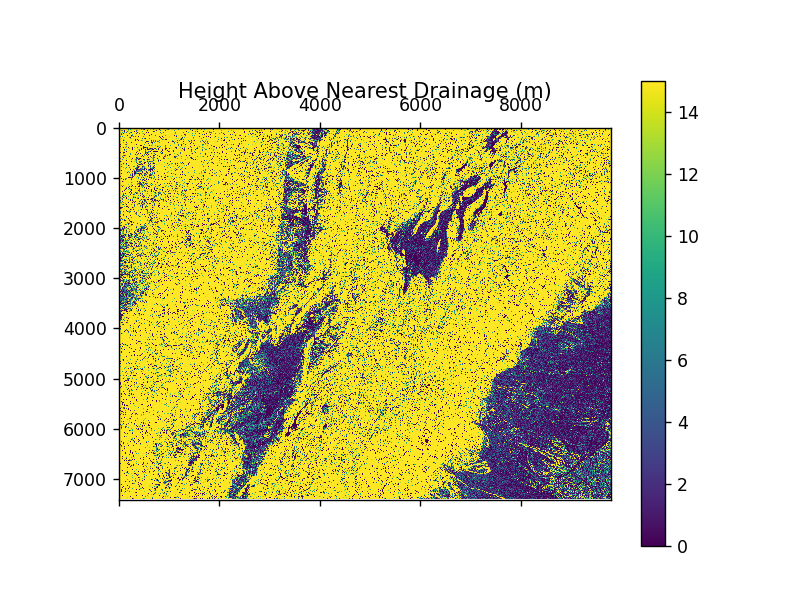

In [19]:
#calculate mean and std.dev. for HAND
m=np.nanmean(hand) 
s=np.nanstd(hand)
#minimum value should be no lower than 0. 
hmin=max(m-2*s,0)
#If there is a large variation, just show the first 15m. 
hmax=min(m+2.5*s,15)
print(f"Setting colorbar limits as min:{hmin} max:{hmax}")
pl.matshow(hand);pl.colorbar();pl.clim([hmin,hmax]);pl.title('Height Above Nearest Drainage (m)');
